In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/28 16:10:55 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/10/28 16:10:57 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_124/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### df Spark

In [4]:
# # Данные обучения предыдущей модели:
# # df_spark = spark.read.table('b2b_cltv_stg.vpg_ml_potential_models_train_oct24_v2_temp_delete')

# # b2b_cltv_stg.cvm_box_ml_features_v1 - выручка

# df_prod_rev = spark.read.table('b2b_cltv_stg.cvm_box_ml_features_v1')

# print('num_rows:', df_prod_rev.count())  
# print('num_cols:', len(df_prod_rev.columns))  
# df_prod_rev.show(5)

# # num_rows: 108 642
# # num_cols: 6

In [5]:
# df_prod_rev_pd = df_prod_rev.toPandas()

# print(df_prod_rev_pd.shape)
# df_prod_rev_pd.head(2)

# # (108 642, 6)

#### to Pandas

In [6]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sum', 'min', 'datetime', 'mean', 'max']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### b2b_cltv_stg.cvm_box_ml_features_v1

In [8]:
# df_prod_rev = spark.read.table("b2b_cltv_stg.cvm_box_ml_features_v1")

# print('num_rows:', df_prod_rev.count())  
# df_prod_rev.printSchema()

In [8]:
# df.to_pickle('df_products.pkl')
df_prod_rev_pd = pd.read_pickle('df_products.pkl')

# df_prod_rev_pd = df_prod_rev.toPandas()

print(df_prod_rev_pd.shape)
df_prod_rev_pd.head(2)

# # (108 642, 6)

(108642, 6)


,client_inn,revenue,traf_internet_amt,traf_voice_amt,product_name,calendar_dt
0,5906996069,99905.3900,None,None,m2m_cup,2025-03-01
1,1513059178,8326.7400,None,None,m2m_cup,2025-03-01


In [9]:
df_prod_rev_pd['calendar_dt'].value_counts()

2025-06-01    7048
2025-05-01    6931
2025-04-01    6893
2025-03-01    6705
2025-02-01    6528
2025-01-01    6378
2024-12-01    6275
2024-11-01    6125
2024-10-01    6022
2024-09-01    5920
2024-08-01    5798
2024-07-01    5689
2024-06-01    5586
2024-05-01    5513
2024-04-01    5434
2024-03-01    5348
2024-02-01    5250
2024-01-01    5199
Name: calendar_dt, dtype: int64

<Figure size 2000x4000 with 0 Axes>

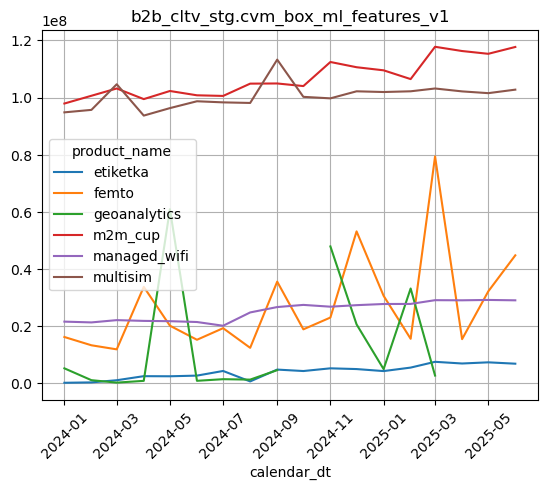

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(20, 40)

df_agg = df_prod_rev_pd.groupby(['calendar_dt', 'product_name'])['revenue'].sum().astype(int).unstack().plot()
plt.title("b2b_cltv_stg.cvm_box_ml_features_v1")
plt.xticks(rotation = 45)
plt.grid()

In [11]:
df_prod_rev_pd['product_name'].value_counts()

m2m_cup         40796
multisim        26906
managed_wifi    19869
etiketka        11725
femto            9307
geoanalytics       39
Name: product_name, dtype: int64

In [12]:
# df_prod_rev_pd['calendar_dt'].value_counts()

In [13]:
# df_prod_rev_pd[df_prod_rev_pd['product_name'] == 'm2m_cup'][['client_inn', 'calendar_dt']].groupby('client_inn')['calendar_dt'].count()

In [14]:
df_prod_rev_pd['client_inn'].nunique()

7968

In [15]:
df_prod_rev_pd[df_prod_rev_pd['product_name'] == 'm2m_cup']['client_inn'].nunique()

2628

In [16]:
# 2628 / 108642

#### Aggregation

In [17]:
print(df_prod_rev_pd.shape)
df_prod_rev_pd.head(3)

(108642, 6)


,client_inn,revenue,traf_internet_amt,traf_voice_amt,product_name,calendar_dt
0,5906996069,99905.3900,None,None,m2m_cup,2025-03-01
1,1513059178,8326.7400,None,None,m2m_cup,2025-03-01
2,3827041873,7213.5400,None,None,m2m_cup,2025-03-01


In [18]:
df_prod_rev_pd.groupby(['client_inn', 'product_name'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum', 'calendar_dt': 'min'})

,,revenue,traf_internet_amt,traf_voice_amt,calendar_dt
client_inn,product_name,,,,
0000000000,m2m_cup,4419.4000,0,0,2024-01-01
0100000491,femto,8400.0000,0.000000,8400.000000,2024-02-01
0102000578,etiketka,3854.7200,0,0,2025-04-01
0104009061,etiketka,445.2000,0,0,2025-03-01
010501573834,m2m_cup,57252.0100,0,0,2024-01-01
...,...,...,...,...,...
9909267657,femto,22214.2900,0.000000,22214.290000,2025-02-01
9909342488,managed_wifi,648000.0000,0.000000,0.000000,2024-01-01
9909400972,femto,36709.6800,0.000000,36709.680000,2024-10-01


#### df_agg_prod

In [19]:
df_agg_prod = df_prod_rev_pd.groupby(['client_inn', 'product_name'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum', 'calendar_dt': 'min'}).reset_index()

print(df_agg_prod.shape)
df_agg_prod.head()

(8611, 6)


,client_inn,product_name,revenue,traf_internet_amt,traf_voice_amt,calendar_dt
0,0000000000,m2m_cup,4419.4000,0,0,2024-01-01
1,0100000491,femto,8400.0000,0.000000,8400.000000,2024-02-01
2,0102000578,etiketka,3854.7200,0,0,2025-04-01
3,0104009061,etiketka,445.2000,0,0,2025-03-01
4,010501573834,m2m_cup,57252.0100,0,0,2024-01-01


In [20]:
df_prod_rev_pd['m2m_flag'] = df_prod_rev_pd['product_name'].apply(lambda x: 1 if x == 'm2m_cup' else 0)

df_prod_rev_pd['m2m_flag'].value_counts()

0    67846
1    40796
Name: m2m_flag, dtype: int64

In [21]:
print(df_prod_rev_pd.shape)
# df_prod_rev_pd

(108642, 7)


In [22]:
# df_prod_rev_pd['calendar_dt'].value_counts()

In [23]:
print(df_prod_rev_pd.shape)

df_agg_prod_1 = df_prod_rev_pd.groupby(['client_inn', 'product_name', 'calendar_dt'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum'}).reset_index()

print(df_agg_prod_1.shape)
df_agg_prod_1.head()

(108642, 7)
(108642, 6)


,client_inn,product_name,calendar_dt,revenue,traf_internet_amt,traf_voice_amt
0,0000000000,m2m_cup,2024-01-01,206.4500,0,0
1,0000000000,m2m_cup,2024-02-01,206.4500,0,0
2,0000000000,m2m_cup,2024-03-01,206.4500,0,0
3,0000000000,m2m_cup,2024-04-01,206.4500,0,0
4,0000000000,m2m_cup,2024-05-01,206.4500,0,0


In [24]:
df_prod_rev_pd['m2m_flag'] = df_prod_rev_pd['product_name'].apply(lambda x: 1 if x == 'm2m_cup' else 0)
df_prod_rev_pd['m2m_flag'].value_counts()

0    67846
1    40796
Name: m2m_flag, dtype: int64

In [25]:
df_prod_rev_pd.head()

,client_inn,revenue,traf_internet_amt,traf_voice_amt,product_name,calendar_dt,m2m_flag
0,5906996069,99905.3900,None,None,m2m_cup,2025-03-01,1
1,1513059178,8326.7400,None,None,m2m_cup,2025-03-01,1
2,3827041873,7213.5400,None,None,m2m_cup,2025-03-01,1
3,9724063259,7905.7400,None,None,m2m_cup,2025-03-01,1
4,9715452001,270.1400,None,None,m2m_cup,2025-03-01,1


In [26]:
df_agg_prod_1['calendar_dt_lagged'] = df_agg_prod_1.groupby(['client_inn', 'product_name'])['calendar_dt'].shift(1)
# df_agg_prod_1

#### Таблицы контур фокус

ОКВЭД

In [27]:
# spark.read.table("b2bs_dm.kontur_focus_okvades").show(5)

#### Финансовая отчётность для ИНН

In [28]:
df_fin_report = spark.read.table("b2bs_dm.kontur_focus_buh_data")

df_fin_report.show(5)

+----------+----+----+--------------------+-----------+---------+-----------------+-----+
|       inn|year|code|          name_param|start_value|end_value|organization_type| form|
+----------+----+----+--------------------+-----------+---------+-----------------+-----+
|3906070115|2012|1100|               Итого|   49356000| 59464000|            Large|form1|
|3906070115|2012|1110|Нематериальные ак...|          0|        0|            Large|form1|
|3906070115|2012|1120|Результаты исслед...|          0|        0|            Large|form1|
|3906070115|2012|1130|Нематериальные по...|          0|        0|            Large|form1|
|3906070115|2012|1140|Материальные поис...|          0|        0|            Large|form1|
+----------+----+----+--------------------+-----------+---------+-----------------+-----+
only showing top 5 rows



In [29]:
df_fin_report_pd = df_fin_report.toPandas()

print(df_fin_report_pd.shape)
df_fin_report_pd.head(3)

# (136140325, 8)

25/10/28 16:49:16 ERROR TransportChannelHandler: Connection to hdp3-llap-2.dmp.vimpelcom.ru/10.31.153.227:40485 has been quiet for 120000 ms while there are outstanding requests. Assuming connection is dead; please adjust spark.shuffle.io.connectionTimeout if this is wrong.
25/10/28 16:49:16 ERROR TransportResponseHandler: Still have 3 requests outstanding when connection from hdp3-llap-2.dmp.vimpelcom.ru/10.31.153.227:40485 is closed
25/10/28 16:49:16 ERROR OneForOneBlockFetcher: Failed while starting block fetches
java.io.IOException: Connection from hdp3-llap-2.dmp.vimpelcom.ru/10.31.153.227:40485 closed
	at org.apache.spark.network.client.TransportResponseHandler.channelInactive(TransportResponseHandler.java:147)
	at org.apache.spark.network.server.TransportChannelHandler.channelInactive(TransportChannelHandler.java:117)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelInactive(AbstractChannelHandlerContext.java:305)
	at io.netty.channel.AbstractChannelHandlerContext

(136140325, 8)


,inn,year,code,name_param,start_value,end_value,organization_type,form
0,3906070115,2012,1100,Итого,49356000.0,59464000.0,Large,form1
1,3906070115,2012,1110,Нематериальные активы,0.0,0.0,Large,form1
2,3906070115,2012,1120,Результаты исследований и разработок,0.0,0.0,Large,form1


In [30]:
print(df_fin_report_pd.shape)
df_fin_report_pd.head(3)

(136140325, 8)


,inn,year,code,name_param,start_value,end_value,organization_type,form
0,3906070115,2012,1100,Итого,49356000.0,59464000.0,Large,form1
1,3906070115,2012,1110,Нематериальные активы,0.0,0.0,Large,form1
2,3906070115,2012,1120,Результаты исследований и разработок,0.0,0.0,Large,form1


In [31]:
# spark.read.table("b2bba_prod.fa_report_detail_new").show(5)

#### Таблица от ba с выручкой по продуктам и группам продуктов

Можно использовать для сбора базы ИНН

In [32]:
# fa_revenue = (
#     spark.read.table("b2bba_prod.fa_report_detail_new")
#     .groupBy("dt", "revenue_type")
#     .agg(F.sum(F.col("revenue")).alias("revenue"))
# ).toPandas()

In [33]:
# # пример сбора базы ИНН на определенный месяц
# spark.read.table("b2bba_prod.fa_report_detail_new").filter(F.col("dt") == "2025-03-01").select("inn").dropDuplicates().count()

In [34]:
# ********************************************************************************************************************************

#### b2b_profile.cvm_box_customer

In [35]:
df_cvm_box = spark.read.table('b2b_profile.cvm_box_customer')

print('num_rows:', df_cvm_box.count())  
print('num_cols:', len(df_cvm_box.columns))  
df_cvm_box.show(5)

# num_rows: 303 099
# num_cols: 12

# num_rows: 413 103
# num_cols: 14

num_rows: 413103
num_cols: 14


+--------------------+----------+------------+--------------------+----------------+------+--------+----------------+---------+--------------------+-------+-----------+---------------------+-----------+
|          acrm_objid|   cust_id|    cust_inn|           cust_name|cust_segment_key| state|    type|characterization|hq_market|          site_objid|is_lead|lead_source|first_ban_create_date|update_date|
+--------------------+----------+------------+--------------------+----------------+------+--------+----------------+---------+--------------------+-------+-----------+---------------------+-----------+
|1302011134.000000...|2148197299|673204580878|Физическое лицо М...|              SH|Active|      ИП|         Выбрать|      SML|268435576.0000000000|   NULL|       NULL|           2025-03-12| 2025-10-27|
|  1038774.0000000000|   1038775|  1832060469| Фармаимпекс Консалт|              LA|Active|Юр. лицо|        NATIONAL|      IGK|268435617.0000000000|   NULL|       NULL|           2016-11-1

In [36]:
# df_cvm_box.select('update_date').dropDuplicates().show()

# train: 2025-08-13

In [37]:
df_cvm_box.select('update_date').dropDuplicates().show()

# scoring: 2025-10-27

+-----------+
|update_date|
+-----------+
| 2025-10-27|
+-----------+



In [38]:
df_cvm_box_pd = df_cvm_box.toPandas()

print(df_cvm_box_pd.shape)
df_cvm_box_pd.head()

(413103, 14)


,acrm_objid,cust_id,cust_inn,cust_name,cust_segment_key,state,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,update_date
0,1302011134.0000000000,2148197299,673204580878,Физическое лицо Михаил,SH,Active,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,2025-10-27
1,1038774.0000000000,1038775,1832060469,Фармаимпекс Консалт,LA,Active,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,2025-10-27
2,1278944.0000000000,1277039,7726687812,"Сервис Плюс, ООО",SH,Active,Юр. лицо,Обычный,VIP,268435563.0000000000,NaN,None,2012-12-11,2025-10-27
3,1300835181.0000000000,2147748493,3625012887,МЯСОКОМБИНАТ БОГДАНОВСКИЙ,ME,Active,Юр. лицо,Не определено,VRN,268435564.0000000000,NaN,None,2020-06-04,2025-10-27
4,12691.0000000000,12692,7710558321,"Авиа Бизнес Групп, ООО",ME,Active,Юр. лицо,Обычный,VIP,268435563.0000000000,NaN,None,2007-03-16,2025-10-27


In [39]:
df_cvm_box_pd.drop('acrm_objid', axis = 1, inplace = True)

print(df_cvm_box_pd.shape)
df_cvm_box_pd.head(2)

(413103, 13)


,cust_id,cust_inn,cust_name,cust_segment_key,state,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,update_date
0,2148197299,673204580878,Физическое лицо Михаил,SH,Active,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,2025-10-27
1,1038775,1832060469,Фармаимпекс Консалт,LA,Active,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,2025-10-27


In [40]:
df_cvm_box_pd['type'].value_counts()

Юр. лицо    287495
ИП          125608
Name: type, dtype: int64

In [41]:
df_cvm_box_pd['cust_segment_key'].value_counts()

SH        272225
SE         75254
ME         30608
LA         19726
SH GOS      5854
KA          4338
SE GOS      1802
ME GOS      1580
KA GOS      1213
LA GOS       503
Name: cust_segment_key, dtype: int64

In [42]:
df_cvm_box_pd['site_objid'].value_counts()

268435563.0000000000    109481
268435580.0000000000     25045
268435584.0000000000     14431
268435603.0000000000     13591
268435582.0000000000     13327
                         ...  
268435642.0000000000        97
268435635.0000000000        82
268435601.0000000000        70
268435625.0000000000        42
268435626.0000000000        22
Name: site_objid, Length: 87, dtype: int64

In [43]:
df_cvm_box_pd['first_ban_create_date'].value_counts()

2007-03-01    4263
2020-12-23    1681
2014-11-13    1036
2003-08-12    1007
2011-09-30     623
              ... 
2019-08-25       1
2004-06-12       1
2001-05-23       1
2001-03-26       1
1998-02-17       1
Name: first_ban_create_date, Length: 8298, dtype: int64

In [44]:
df_cvm_box_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413103 entries, 0 to 413102
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cust_id                413103 non-null  object 
 1   cust_inn               413103 non-null  object 
 2   cust_name              413103 non-null  object 
 3   cust_segment_key       413103 non-null  object 
 4   state                  413103 non-null  object 
 5   type                   413103 non-null  object 
 6   characterization       413103 non-null  object 
 7   hq_market              413077 non-null  object 
 8   site_objid             413103 non-null  object 
 9   is_lead                108458 non-null  float64
 10  lead_source            108458 non-null  object 
 11  first_ban_create_date  304329 non-null  object 
 12  update_date            413103 non-null  object 
dtypes: float64(1), object(12)
memory usage: 41.0+ MB


In [45]:
df_cvm_box_pd.nunique()

cust_id                  413103
cust_inn                 413103
cust_name                386016
cust_segment_key             10
state                         5
type                          2
characterization              7
hq_market                    87
site_objid                   87
is_lead                       1
lead_source                   4
first_ban_create_date      8298
update_date                   1
dtype: int64

In [46]:
print(df_cvm_box_pd.shape)

df_cvm_box_pd.drop(['state', 'update_date'], axis = 1, inplace = True)

print(df_cvm_box_pd.shape)

(413103, 13)
(413103, 11)


In [47]:
df_cvm_box_pd.head(2)

,cust_id,cust_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17


In [48]:
# # df_cvm_box_pd.to_pickle('df_cvm_box_pd.pkl')
# # df_cvm_box_pd = pd.read_pickle('df_cvm_box_pd.pkl')

# print(df_cvm_box_pd.shape)
# df_cvm_box_pd.head(2)

# # (302402, 9)

#### join inn with flags

In [49]:
print(df_prod_rev_pd.shape)
df_prod_rev_pd.head(2)

(108642, 7)


,client_inn,revenue,traf_internet_amt,traf_voice_amt,product_name,calendar_dt,m2m_flag
0,5906996069,99905.3900,None,None,m2m_cup,2025-03-01,1
1,1513059178,8326.7400,None,None,m2m_cup,2025-03-01,1


In [50]:
df_prod_rev_pd['product_name'].value_counts()

m2m_cup         40796
multisim        26906
managed_wifi    19869
etiketka        11725
femto            9307
geoanalytics       39
Name: product_name, dtype: int64

In [51]:
df_agg_prod = df_prod_rev_pd.groupby(['client_inn', 'product_name'])[['revenue', 'traf_internet_amt', 'traf_voice_amt', 'calendar_dt']] \
        .agg({'revenue': 'sum', 'traf_internet_amt': 'sum', 'traf_voice_amt': 'sum', 'calendar_dt': 'min'}).reset_index()

# 8611
print(df_agg_prod.shape)
df_agg_prod.head()

(8611, 6)


,client_inn,product_name,revenue,traf_internet_amt,traf_voice_amt,calendar_dt
0,0000000000,m2m_cup,4419.4000,0,0,2024-01-01
1,0100000491,femto,8400.0000,0.000000,8400.000000,2024-02-01
2,0102000578,etiketka,3854.7200,0,0,2025-04-01
3,0104009061,etiketka,445.2000,0,0,2025-03-01
4,010501573834,m2m_cup,57252.0100,0,0,2024-01-01


In [52]:
df_agg_prod['client_inn'].nunique()

7968

In [53]:
df_agg_prod['calendar_dt'].max()

datetime.date(2025, 6, 1)

In [54]:
df_agg_prod['client_inn'].value_counts()

7710140679      6
7744001497      5
3917032714      4
7728551528      4
5406121446      4
               ..
420209042430    1
420208346202    1
4202049983      1
4202048010      1
9909550664      1
Name: client_inn, Length: 7968, dtype: int64

In [55]:
df_agg_prod[df_agg_prod['client_inn'] == '7710140679']

,client_inn,product_name,revenue,traf_internet_amt,traf_voice_amt,calendar_dt
6475,7710140679,etiketka,33930.7200,0,0,2024-01-01
6476,7710140679,femto,21123871.0000,0.000000,21123871.000000,2024-04-01
6477,7710140679,geoanalytics,1000000.0000,0,0,2024-07-01
6478,7710140679,m2m_cup,36242.2500,0,0,2024-01-01
6479,7710140679,managed_wifi,28357881.7900,0.000000,0.000000,2024-01-01
6480,7710140679,multisim,38040662.5100,0.000000,0.000000,2024-01-01


In [56]:
df_agg_prod[df_agg_prod['product_name'] == 'm2m_cup'].shape

(2628, 6)

In [57]:
df_agg_prod[df_agg_prod['product_name'] == 'm2m_cup']['client_inn'].nunique()

2628

In [58]:
df_cvm_box_pd.rename(columns = {'cust_inn': 'client_inn'}, inplace = True)

In [59]:
df_cvm_box_products = df_cvm_box_pd.merge(df_agg_prod[['client_inn', 'product_name', 'revenue', 
                                                       'traf_internet_amt', 'traf_voice_amt']], how = 'left', on = 'client_inn')

print(df_cvm_box_pd.shape)
print(df_cvm_box_products.shape)
df_cvm_box_products.head(2)

(413103, 11)
(413718, 15)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.0000,0.000000,0.000000


In [60]:
303042 - 302402

640

In [61]:
df_cvm_box_products.drop_duplicates().shape

(413718, 15)

In [62]:
df_cvm_box_products.groupby(['client_inn', 'product_name'])['client_inn'].count().unique()

array([1])

In [63]:
df_cvm_box_products['product_name'].value_counts()

m2m_cup         2379
etiketka        1849
multisim        1578
managed_wifi    1267
femto            870
geoanalytics      22
Name: product_name, dtype: int64

In [64]:
df_cvm_box_products['client_inn'].nunique()

413103

In [65]:
"{:.2%}".format(2350 / 303099)

'0.78%'

In [66]:
# OGRN

df_okvades = spark.read.table("b2bs_dm.kontur_focus_okvades").toPandas()
print(df_okvades.shape)
df_okvades.head(2)

# (99 309 526, 6)

25/10/28 16:57:28 ERROR TransportChannelHandler: Connection to hdp3-dn-166.dmp.vimpelcom.ru/10.31.153.141:42693 has been quiet for 120000 ms while there are outstanding requests. Assuming connection is dead; please adjust spark.shuffle.io.connectionTimeout if this is wrong.
25/10/28 16:57:28 ERROR TransportResponseHandler: Still have 3 requests outstanding when connection from hdp3-dn-166.dmp.vimpelcom.ru/10.31.153.141:42693 is closed
25/10/28 16:57:28 ERROR OneForOneBlockFetcher: Failed while starting block fetches
java.io.IOException: Connection from hdp3-dn-166.dmp.vimpelcom.ru/10.31.153.141:42693 closed
	at org.apache.spark.network.client.TransportResponseHandler.channelInactive(TransportResponseHandler.java:147)
	at org.apache.spark.network.server.TransportChannelHandler.channelInactive(TransportChannelHandler.java:117)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelInactive(AbstractChannelHandlerContext.java:305)
	at io.netty.channel.AbstractChannelHandlerContext

(99309526, 6)


,inn,ogrn,code,text,type,update_date
0,1208003820,1021200648787,85.41,Образование дополнительное детей и взрослых,complementaryActivity,2025-08-07
1,1503014763,1021500673260,42.11,Строительство автомобильных дорог и автомагист...,complementaryActivity,2025-08-07


In [67]:
df_okvades['update_date'].value_counts()

2025-08-07    99309526
Name: update_date, dtype: int64

In [68]:
df_okvades['type'].value_counts()

complementaryActivity    91665055
principalActivity         7644471
Name: type, dtype: int64

In [69]:
df_okvades.rename(columns = {'inn': 'client_inn'}, inplace = True)

In [70]:
df_okvades_agg = df_okvades[['client_inn', 'ogrn']].groupby('client_inn').max().reset_index()
df_okvades_agg.head(2)

,client_inn,ogrn
0,000000000049,305000000000000
1,007150001866,305073211440010


In [71]:
df_cvm_prod_ogrn = df_cvm_box_products.merge(df_okvades_agg, how = 'left', on = 'client_inn')

# (302611, 10)
print(df_cvm_prod_ogrn.shape)
df_cvm_prod_ogrn.head(2)

# (413718, 15)

(413718, 16)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN,317673300038089
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.0000,0.000000,0.000000,1071832005630


In [72]:
# *** Фин отчетность для ИНН: ***

print(df_fin_report_pd.shape)
df_fin_report_pd.head(2)

(136140325, 8)


,inn,year,code,name_param,start_value,end_value,organization_type,form
0,3906070115,2012,1100,Итого,49356000.0,59464000.0,Large,form1
1,3906070115,2012,1110,Нематериальные активы,0.0,0.0,Large,form1


In [73]:
df_fin_report_pd['organization_type'].value_counts()

Large    102913274
Small     32867335
SONO        359716
Name: organization_type, dtype: int64

In [74]:
df_fin_report_pd['form'].value_counts()

form1    88109886
form2    48030439
Name: form, dtype: int64

In [75]:
df_fin_report_pd.rename(columns = {'inn': 'client_inn'}, inplace = True)

In [76]:
df_fin_report_pd['client_inn'].nunique()

535820

In [77]:
# df_fin_report_pd[['client_inn', 'organization_type', 'form', 'start_value', 'end_value']].groupby(['client_inn', 'organization_type', 'form']) \
#                                 [['start_value', 'end_value']].sum().reset_index()

df_fin_report_agg =  df_fin_report_pd[['client_inn', 'start_value', 'end_value']].groupby(['client_inn']) \
                                [['start_value', 'end_value']].sum().reset_index()

print(df_fin_report_agg.shape)
df_fin_report_agg.head(3)

# 535 820 

(535820, 3)


,client_inn,start_value,end_value
0,0100000491,1.173570e+10,3.040380e+10
1,0100000607,6.506000e+06,3.122400e+07
2,0100000710,2.809000e+06,2.679600e+07


In [78]:
df_cvm_prod_ogrn_fin = df_cvm_prod_ogrn.merge(df_fin_report_agg, how = 'left', on = 'client_inn')

print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.head(2)

# (413718, 15)

(413718, 18)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN,317673300038089,NaN,NaN
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.0000,0.000000,0.000000,1071832005630,1.370017e+10,1.611297e+10


In [79]:
df_cvm_prod_ogrn_fin['start_value'].isna().sum()

215951

In [80]:
# ****************************************************************************************************************************************

#### b2bba_dm.fa_revenue_detail

In [81]:
df_revenue_detail = spark.read.table("b2bba_dm.fa_revenue_detail")

print(df_revenue_detail.count())
df_revenue_detail.show(5)

# 22 750 779

22750779


+-------------------+-----------+----------+---------+-----------+---------------+-----------------+------+---+-----------------+-------+----------+----------+-------+--------+-------------+----------+-------+--------+--------------------+-------------+----------+------------+---------+------+-------+-------------------+--------------------+
|                 dt|contract_no|       inn|client_id|client_name|client_group_id|client_group_name|region|mkt|           market|segment|subsegment|flag_agent|flag_mk|flag_gos|flag_national|flag_alloc|flag_sp|flag_otm|               sales|     sales_tn|sales_func|revenue_type|  account|domain|revenue|        source_name|           load_date|
+-------------------+-----------+----------+---------+-----------+---------------+-----------------+------+---+-----------------+-------+----------+----------+-------+--------+-------------+----------+-------+--------+--------------------+-------------+----------+------------+---------+------+-------+----------

In [82]:
df_revenue_detail_pd = df_revenue_detail.toPandas()

df_revenue_detail_pd['load_date'].value_counts()

2025-10-24 00:02:10.673    22750779
Name: load_date, dtype: int64

In [83]:
df_revenue_detail_pd['dt'].sort_values().value_counts()

2024-01-01    1125739
2024-02-01    1114551
2024-03-01    1102700
2024-04-01    1100348
2024-05-01    1083986
2024-07-01    1083880
2025-09-01    1083820
2024-08-01    1083466
2025-04-01    1082335
2024-06-01    1081415
2024-10-01    1080641
2025-08-01    1079239
2024-09-01    1078202
2024-12-01    1078149
2025-07-01    1075236
2025-03-01    1072818
2024-11-01    1071638
2025-06-01    1071230
2025-05-01    1071022
2025-01-01    1067147
2025-02-01    1063217
Name: dt, dtype: int64

In [84]:
df_revenue_detail_pd[df_revenue_detail_pd['dt'] == '2025-06-01']['inn'].nunique()

233090

In [85]:
dt_rev_max = df_revenue_detail_pd['dt'].max()
dt_rev_max

Timestamp('2025-09-01 00:00:00')

In [86]:
df_revenue_detail_dt = df_revenue_detail_pd[df_revenue_detail_pd['dt'] == dt_rev_max]

print(df_revenue_detail_dt.shape)
df_revenue_detail_dt.head(2)

(1083820, 28)


,dt,contract_no,inn,client_id,client_name,client_group_id,client_group_name,region,mkt,market,...,flag_otm,sales,sales_tn,sales_func,revenue_type,account,domain,revenue,source_name,load_date
743493,2025-09-01,HL805,5405343358,353566,"""Компания Пеликан""",None,None,Центр,KZN,Казанский ф-л,...,0,Калачикова Екатерина Сергеевна,203625,Sales LA,fix_internet,Internet,Core,925.00,fix_revenue_monthly,2025-10-24 00:02:10.673
743494,2025-09-01,HL805,5405343358,353566,"""Компания Пеликан""",None,None,Центр,PRM,Пермский ф-л,...,0,Калачикова Екатерина Сергеевна,203625,Sales LA,fix_internet,Internet,Core,2775.00,fix_revenue_monthly,2025-10-24 00:02:10.673


In [87]:
df_revenue_inn_dt = df_revenue_detail_dt['inn'].unique()
print(df_revenue_inn_dt.shape)
df_revenue_inn_dt

(235219,)


array(['5405343358', '7453048035', '7106043367', ..., '5407495444',
       '312321896073', '6025041761'], dtype=object)

In [88]:
print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.head(2)

(413718, 18)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN,317673300038089,NaN,NaN
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.0000,0.000000,0.000000,1071832005630,1.370017e+10,1.611297e+10


In [89]:
df_inn_cvm_box = df_cvm_prod_ogrn_fin['client_inn'].unique()
print(df_inn_cvm_box.shape)
df_inn_cvm_box

(413103,)


array(['673204580878', '1832060469', '7726687812', ..., '614310003805',
       '500315380624', '614199584973'], dtype=object)

In [90]:
len(set(df_inn_cvm_box).intersection(set(df_revenue_inn_dt)))

219025

In [91]:
len(set(df_revenue_inn_dt).intersection(set(df_inn_cvm_box)))

219025

In [92]:
print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.head(2)

(413718, 18)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,revenue,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN,317673300038089,NaN,NaN
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.0000,0.000000,0.000000,1071832005630,1.370017e+10,1.611297e+10


In [93]:
print(df_revenue_detail_dt.shape)
df_revenue_detail_dt.iloc[:2, :14]

(1083820, 28)


,dt,contract_no,inn,client_id,client_name,client_group_id,client_group_name,region,mkt,market,segment,subsegment,flag_agent,flag_mk
743493,2025-09-01,HL805,5405343358,353566,"""Компания Пеликан""",None,None,Центр,KZN,Казанский ф-л,LA,LA,0,0
743494,2025-09-01,HL805,5405343358,353566,"""Компания Пеликан""",None,None,Центр,PRM,Пермский ф-л,LA,LA,0,0


In [94]:
print(df_revenue_detail_dt.shape)
df_revenue_detail_dt.iloc[:2, 14:]

(1083820, 28)


,flag_gos,flag_national,flag_alloc,flag_sp,flag_otm,sales,sales_tn,sales_func,revenue_type,account,domain,revenue,source_name,load_date
743493,0.0,None,1,0,0,Калачикова Екатерина Сергеевна,203625,Sales LA,fix_internet,Internet,Core,925.00,fix_revenue_monthly,2025-10-24 00:02:10.673
743494,0.0,None,1,0,0,Калачикова Екатерина Сергеевна,203625,Sales LA,fix_internet,Internet,Core,2775.00,fix_revenue_monthly,2025-10-24 00:02:10.673


In [95]:
# df_revenue_detail_dt['inn'].value_counts()

In [96]:
# df_revenue_detail_dt['revenue_type'].value_counts()

In [97]:
# df_revenue_detail_dt[df_revenue_detail_dt['inn'] == '6671460670']

In [98]:
df_revenue_dt_rev_AGG = df_revenue_detail_dt.groupby(['inn', 'region', 'mkt', 'market', 'subsegment', 'flag_agent', 'flag_mk', 'flag_gos', 'flag_national',
'flag_alloc', 'flag_sp', 'flag_otm', 'sales_func', 'revenue_type', 'account', 'domain', 'source_name'])[['revenue']].sum().reset_index()

print(df_revenue_dt_rev_AGG.shape)
df_revenue_dt_rev_AGG.head(2)

(0, 18)


,inn,region,mkt,market,subsegment,flag_agent,flag_mk,flag_gos,flag_national,flag_alloc,flag_sp,flag_otm,sales_func,revenue_type,account,domain,source_name,revenue


In [99]:
df_revenue_dt_rev_AGG['mkt'].value_counts()

Series([], Name: mkt, dtype: int64)

In [100]:
df_revenue_dt_rev_AGG['inn'].nunique()

0

In [101]:
df_revenue_detail_dt['inn'].nunique()

235218

In [102]:
df_revenue_detail_dt['inn'].value_counts()

7744000912      4712
6671460670      4138
7728029110      4132
7707548740      3777
2310031475      3237
                ... 
2635016367         1
6816005558         1
4304000546         1
410101753424       1
6025041761         1
Name: inn, Length: 235218, dtype: int64

In [103]:
# df_revenue_detail_dt[df_revenue_detail_dt['inn'] == '6671460670']

In [104]:
print(df_revenue_detail_dt.shape)
df_revenue_detail_dt = df_revenue_detail_dt[~df_revenue_detail_dt['inn'].isin(['-', '.'])]
print(df_revenue_detail_dt.shape)

(1083820, 28)
(1083809, 28)


In [105]:
df_revenue_detail_dt_INN = df_revenue_detail_dt[['inn', 'revenue']].groupby(['inn'])['revenue'].sum().reset_index()
df_revenue_detail_dt_INN.rename(columns = {'inn': 'client_inn', 'revenue': 'revenue_detail_sum'}, inplace = True)
df_revenue_detail_dt_INN.head(3)

,client_inn,revenue_detail_sum
0,0000000000,1052207.20
1,000000000000,63097.27
2,0015300361,430.70


In [106]:
print(df_cvm_prod_ogrn_fin.shape)
df_cvm_prod_ogrn_fin.rename(columns = {'revenue': 'revenue_product'}, inplace = True)

df_cvm_prod_ogrn_fin_rev = df_cvm_prod_ogrn_fin.merge(df_revenue_detail_dt_INN, on = 'client_inn', how = 'left')
print(df_cvm_prod_ogrn_fin_rev.shape)
df_cvm_prod_ogrn_fin_rev.head(3)

(413718, 18)
(413718, 19)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,revenue_product,traf_internet_amt,traf_voice_amt,ogrn,start_value,end_value,revenue_detail_sum
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN,317673300038089,NaN,NaN,1007.70
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.0000,0.000000,0.000000,1071832005630,1.370017e+10,1.611297e+10,1848367.00
2,1277039,7726687812,"Сервис Плюс, ООО",SH,Юр. лицо,Обычный,VIP,268435563.0000000000,NaN,None,2012-12-11,NaN,NaN,NaN,NaN,1117746994463,8.421100e+07,9.412500e+07,2802.15


In [107]:
df_cvm_prod_ogrn_fin_rev[['revenue_product', 'revenue_detail_sum']]

,revenue_product,revenue_detail_sum
0,NaN,1007.70
1,0.0000,1848367.00
2,NaN,2802.15
3,NaN,NaN
4,NaN,61469.37
...,...,...
413713,NaN,NaN
413714,NaN,NaN
413715,NaN,NaN
413716,NaN,NaN


In [108]:
df_cvm_prod_ogrn_fin_rev[~df_cvm_prod_ogrn_fin_rev['revenue_product'].isna()][['revenue_product', 'revenue_detail_sum']]

,revenue_product,revenue_detail_sum
1,0.0000,1848367.00
5,875340.0000,1233702.57
40,0.0000,5550.00
62,1796795.0000,886796.63
67,49199.8400,2785.06
...,...,...
403127,84.0000,NaN
403151,433900.0700,NaN
403381,72500.0000,NaN
407721,27500.0000,NaN


#### b2b_profile.org_kontur_focus_galaxy

In [109]:
# df_external_2 = spark.read.table('b2b_profile.org_kontur_focus_galaxy')

# df_external_2_pd.to_pickle('df_external_2_pd.pkl')
df_kontur_focus = pd.read_pickle('df_external_2_pd.pkl')

print(df_kontur_focus.shape)
df_kontur_focus.head(2)

# (6 293 630, 47)

(6293630, 47)


,CLIENT_INN,OGRN,LEGAL_NAME,KPP,LEGAL_NAME_SHORT,LEGAL_NAME_FULL,OPF,REGISTRATION_DATE,LEGAL_ADDRESS,REGION_TYPE,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,0100008758,1240100001580,"ООО ""Омнитех Солюшнс""",010001001,"ООО ""ОМНИТЕХ СОЛЮШНС""","ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОМНИ...",Общества с ограниченной ответственностью,2024-06-06,"385141, Республика Адыгея (Адыгея), м.р-н Тахт...",республика,...,2024-07-10,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02
1,0100009649,1240100002482,Региональная Физкультурно-Спортивная Обществен...,010001001,"РФС ОО ""ФЛБ"" РА",РЕГИОНАЛЬНАЯ ФИЗКУЛЬТУРНО-СПОРТИВНАЯ ОБЩЕСТВЕН...,Общественные организации,2024-08-30,"385019, Республика Адыгея (Адыгея), г.о. Город...",республика,...,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02


In [110]:
df_kontur_focus['TIME_KEY'].value_counts()

2025-04-02    6293630
Name: TIME_KEY, dtype: int64

In [111]:
# data.columns = [x.lower() for x in data.columns]
# data.columns = map(str.lower, data.columns)

# df_kontur_focus.columns = map(str.lower, df_kontur_focus.columns)
df_kontur_focus.rename(columns = {'CLIENT_INN': 'client_inn'}, inplace = True)
# df_kontur_focus.columns

In [112]:
df_kontur_focus['client_inn'].nunique()

6293630

In [113]:
df_kontur_focus.rename(columns = {'revenue': 'revenue_kontur'}, inplace = True)

In [114]:
print(df_cvm_prod_ogrn_fin_rev.shape)
df_cvm_prod_ogrn_fin_rev.drop('ogrn', axis = 1, inplace = True)
df_cvm_prod_ogrn_fin_rev_focus = df_cvm_prod_ogrn_fin_rev.merge(df_kontur_focus, how = 'left', on = 'client_inn')
print(df_cvm_prod_ogrn_fin_rev_focus.shape)

(413718, 19)
(413718, 64)


In [115]:
17 + 45

62

In [116]:
df_cvm_prod_ogrn_fin_rev_focus.head(2)

,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,...,2017-11-10,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,...,None,None,274.0,2023-12-31,2023.0,493614000.0,2024.0,11596000.0,2024.0,2025-04-02


In [117]:
df_cvm_prod_ogrn_fin_rev_focus.columns

Index(['cust_id', 'client_inn', 'cust_name', 'cust_segment_key', 'type',
       'characterization', 'hq_market', 'site_objid', 'is_lead', 'lead_source',
       'first_ban_create_date', 'product_name', 'revenue_product',
       'traf_internet_amt', 'traf_voice_amt', 'start_value', 'end_value',
       'revenue_detail_sum', 'OGRN', 'LEGAL_NAME', 'KPP', 'LEGAL_NAME_SHORT',
       'LEGAL_NAME_FULL', 'OPF', 'REGISTRATION_DATE', 'LEGAL_ADDRESS',
       'REGION_TYPE', 'REGION_NAME', 'REGION_CODE', 'STATUS', 'BANKRUPTING',
       'DISSOLVED', 'DISSOLVING', 'REORGANIZING', 'STATUS_DATE', 'OKATO',
       'OKFS', 'OKOGU', 'OKOPF', 'OKPO', 'OKTMO', 'DISSOLUTION_DATE', 'AGE',
       'HEADS', 'PRIVACY_FORM', 'OKVED_CODE', 'OKVED_TEXT', 'OKVED_CLASS_CODE',
       'OKVED_CLASS_NAME', 'OKVED_CHAPTER_CODE', 'OKVED_CHAPTER_NAME',
       'INDUSTRY_GROUP', 'STATEDCAPITAL', 'MSP_TYPE', 'MSP_IN_DATE',
       'MSP_OUT_DATE', 'COUNT_EMPLOYEE', 'COUNT_EMPLOYEE_DATE',
       'COUNT_EMPLOYEE_YEAR', 'REVENUE', 'REV

#### Dataset

In [118]:
# df_cvm_prod_ogrn_fin_rev_focus.to_pickle('df_cvm_prod_ogrn_fin_rev_focus_Scoring.pkl')
# df_cvm_prod_ogrn_fin_rev_focus = pd.read_pickle('df_cvm_prod_ogrn_fin_rev_focus_Scoring.pkl')

print(df_cvm_prod_ogrn_fin_rev_focus.shape)
df_cvm_prod_ogrn_fin_rev_focus.head(2)

# (303 042, 62)
# (303 711, 62)
# (413 718, 64)

(413718, 64)


,cust_id,client_inn,cust_name,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,2148197299,673204580878,Физическое лицо Михаил,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,...,2017-11-10,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02
1,1038775,1832060469,Фармаимпекс Консалт,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,...,None,None,274.0,2023-12-31,2023.0,493614000.0,2024.0,11596000.0,2024.0,2025-04-02


In [119]:
# df_cvm_prod_ogrn_fin_rev_focus['REVENUE'].isnull().sum()
# df_cvm_prod_ogrn_fin_rev_focus['revenue_detail_sum'].isnull().sum()
# df_cvm_prod_ogrn_fin_rev_focus['revenue_product'].isnull().sum()
# df_cvm_prod_ogrn_fin_rev_focus[['revenue_product', 'revenue_detail_sum', 'REVENUE']]

In [120]:
df_cvm_prod_ogrn_fin_rev_focus.drop('revenue_product', axis = 1, inplace = True)

In [121]:
df_cvm_prod_ogrn_fin_rev_focus['MSP_OUT_DATE'].value_counts()

2025-01-10    59
2024-11-10    29
2024-10-10    25
2025-02-10    22
2024-12-10    18
2025-03-10    11
Name: MSP_OUT_DATE, dtype: int64

In [122]:
print(df_cvm_prod_ogrn_fin_rev_focus.shape)

df = df_cvm_prod_ogrn_fin_rev_focus.drop(['cust_id', 'cust_name', 'OGRN', 'LEGAL_NAME', 
             'LEGAL_NAME_SHORT', 'LEGAL_NAME_FULL', 
             'REGISTRATION_DATE','LEGAL_ADDRESS', 'HEADS',
             'OKVED_CODE', 'OKVED_TEXT', 'REGION_NAME',
             'DISSOLVING', 'DISSOLUTION_DATE', 
             'COUNT_EMPLOYEE_DATE', 
             'OKVED_CHAPTER_NAME', 'OKVED_CLASS_NAME',
             'STATUS_DATE', 'MSP_IN_DATE', 'MSP_OUT_DATE',
             'KPP', 'OKATO', 'OKFS', 'OKOGU', 'OKOPF', 'OKPO', 'OKTMO',
             'TIME_KEY'], axis = 1).reset_index()

df.drop('index', axis = 1, inplace = True)

print(df.shape)
df.head(2)

(413718, 63)
(413718, 35)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,...,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,STATEDCAPITAL,MSP_TYPE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR
0,673204580878,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,...,L,Недвижимость,NaN,micro,NaN,NaN,NaN,NaN,NaN,NaN
1,1832060469,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,...,M,"Деятельность в области права, включая деятельн...",60000.0,None,274.0,2023.0,493614000.0,2024.0,11596000.0,2024.0


In [123]:
df.iloc[:2, :13]

,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,is_lead,lead_source,first_ban_create_date,product_name,traf_internet_amt,traf_voice_amt,start_value
0,673204580878,SH,ИП,Выбрать,SML,268435576.0000000000,NaN,None,2025-03-12,NaN,NaN,NaN,NaN
1,1832060469,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,NaN,None,2016-11-17,multisim,0.000000,0.000000,1.370017e+10


In [124]:
# for col in df.columns:
#     try:
#         print(f"{col}: {df[col].nunique()}")
#     except Exception as e:
#          print(f"{col}: Error - {e}")

df_nunique = pd.DataFrame(df.nunique().sort_values()).rename(columns = {0: 'nunique'})
cols_to_drop = list(df_nunique[df_nunique['nunique'] <= 1].index)
cols_to_drop

['DISSOLVED', 'BANKRUPTING', 'is_lead', 'traf_internet_amt', 'REORGANIZING']

In [125]:
print(df.shape)
df.drop( cols_to_drop, axis = 1, inplace = True )
print(df.shape)

(413718, 35)
(413718, 30)


In [126]:
# df_null_count = pd.DataFrame(df.isnull().sum())
# df_null_count.rename(columns = {0: 'count_null'}, inplace = True)
# df_null_count['part_null'] = df_null_count['count_null'] / df.shape[0]
# df_null_count

In [127]:
print(df.shape)
df.head(2)

(413718, 30)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,lead_source,first_ban_create_date,product_name,traf_voice_amt,...,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,STATEDCAPITAL,MSP_TYPE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR
0,673204580878,SH,ИП,Выбрать,SML,268435576.0000000000,None,2025-03-12,NaN,NaN,...,L,Недвижимость,NaN,micro,NaN,NaN,NaN,NaN,NaN,NaN
1,1832060469,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,None,2016-11-17,multisim,0.000000,...,M,"Деятельность в области права, включая деятельн...",60000.0,None,274.0,2023.0,493614000.0,2024.0,11596000.0,2024.0


In [128]:
# Dummies: ['cust_segment_key', 'type', 'characterization', ]

# TF-IDF: ['hq_market', 'site_objid', ]

# Dates months from now: ['first_ban_create_date', ]

# Targets: 'product_name'

# 1 unique value: 'traf_internet_amt'

#### Dates

In [129]:
from datetime import datetime

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [130]:
datetime.now()

datetime.datetime(2025, 10, 28, 17, 59, 9, 247557)

In [131]:
df_cvm_prod_ogrn_fin_rev_focus['first_ban_create_date'].dtype

dtype('O')

In [132]:
df['first_ban_create_date'] = df['first_ban_create_date'].astype('datetime64')

# df['MSP_IN_DATE'] = df['MSP_IN_DATE'].astype('datetime64')
# df['MSP_OUT_DATE'] = df['MSP_OUT_DATE'].astype('datetime64')
# df['STATUS_DATE'] = df['STATUS_DATE'].astype('datetime64')
# df['COUNT_EMPLOYEE_DATE'] = df['COUNT_EMPLOYEE_DATE'].astype('datetime64')

In [133]:
df['first_ban_create_date_dist'] = df['first_ban_create_date'].apply(lambda x: diff_month(datetime.now(), x))

df[['first_ban_create_date', 'first_ban_create_date_dist']].head(5)

,first_ban_create_date,first_ban_create_date_dist
0,2025-03-12,7.0
1,2016-11-17,107.0
2,2012-12-11,154.0
3,2020-06-04,64.0
4,2007-03-16,223.0


#### Objects

In [134]:
print(df.select_dtypes(include = ['object']).shape)
df.select_dtypes(include = ['object']).head(2)

# (303042, 18)

(413718, 19)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,lead_source,product_name,traf_voice_amt,revenue_detail_sum,OPF,REGION_TYPE,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,MSP_TYPE
0,673204580878,SH,ИП,Выбрать,SML,268435576.0000000000,None,NaN,NaN,1007.70,Индивидуальные предприниматели,None,None,Действующее,Частная собственность,68,L,Недвижимость,micro
1,1832060469,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,None,multisim,0.000000,1848367.00,Общества с ограниченной ответственностью,республика,18,Действующее,Частная собственность,69,M,"Деятельность в области права, включая деятельн...",None


In [135]:
df['traf_voice_amt'] = df['traf_voice_amt'].astype('float64')
df['revenue_detail_sum'] = df['revenue_detail_sum'].astype('float64')

In [136]:
# Dummies: ['cust_segment_key', 'type', 'characterization', 'OKVED_CHAPTER_CODE', 'MSP_TYPE']

# TF-IDF: ['hq_market', 'site_objid', 'REGION_CODE', 'OPF', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']

# Targets: 'product_name'

In [137]:
# df[['REGION_TYPE', 'REGION_CODE']]

In [138]:
print(df.select_dtypes(include = ['object']).shape)
df.select_dtypes(include = ['object']).head(2)

(413718, 17)


,client_inn,cust_segment_key,type,characterization,hq_market,site_objid,lead_source,product_name,OPF,REGION_TYPE,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,MSP_TYPE
0,673204580878,SH,ИП,Выбрать,SML,268435576.0000000000,None,NaN,Индивидуальные предприниматели,None,None,Действующее,Частная собственность,68,L,Недвижимость,micro
1,1832060469,LA,Юр. лицо,NATIONAL,IGK,268435617.0000000000,None,multisim,Общества с ограниченной ответственностью,республика,18,Действующее,Частная собственность,69,M,"Деятельность в области права, включая деятельн...",None


In [139]:
# df['INDUSTRY_GROUP'].value_counts()

In [140]:
df['REGION_CODE'].map(type).value_counts()

<class 'str'>         279645
<class 'NoneType'>    111305
<class 'float'>        22768
Name: REGION_CODE, dtype: int64

In [141]:
df['REGION_CODE'] = df['REGION_CODE'].apply(lambda x: str(x))
df['REGION_CODE'].map(type).value_counts()

<class 'str'>    413718
Name: REGION_CODE, dtype: int64

In [142]:
df['OKVED_CLASS_CODE'].map(type).value_counts()

<class 'str'>         390757
<class 'float'>        22768
<class 'NoneType'>       193
Name: OKVED_CLASS_CODE, dtype: int64

In [143]:
df['OKVED_CLASS_CODE'] = df['OKVED_CLASS_CODE'].apply(lambda x: str(x))
df['OKVED_CLASS_CODE'].map(type).value_counts()

<class 'str'>    413718
Name: OKVED_CLASS_CODE, dtype: int64

In [144]:
df['site_objid'].map(type).value_counts()

<class 'decimal.Decimal'>    413718
Name: site_objid, dtype: int64

In [145]:
df['site_objid'] = df['site_objid'].apply(lambda x: str(x))
df['site_objid'].map(type).value_counts()

<class 'str'>    413718
Name: site_objid, dtype: int64

#### X

In [146]:
X = df.copy()

In [147]:
# *************************************** Dummies: **************************************************************

categ_columns = ['cust_segment_key', 'type', 'characterization', 'REGION_TYPE', 'MSP_TYPE', 'OKVED_CHAPTER_CODE',
                'product_name']

print(X.shape)
for column in categ_columns: 
    
    dummies = pd.get_dummies(X[column], prefix = column)
    X[dummies.columns] = dummies
    X.drop([column], inplace = True, axis = 1)
print(X.shape)

(413718, 31)
(413718, 80)


In [148]:
X.head(2)

,client_inn,hq_market,site_objid,lead_source,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,OPF,...,OKVED_CHAPTER_CODE_R,OKVED_CHAPTER_CODE_S,OKVED_CHAPTER_CODE_T,OKVED_CHAPTER_CODE_U,product_name_etiketka,product_name_femto,product_name_geoanalytics,product_name_m2m_cup,product_name_managed_wifi,product_name_multisim
0,673204580878,SML,268435576.0000000000,None,2025-03-12,NaN,NaN,NaN,1007.7,Индивидуальные предприниматели,...,0,0,0,0,0,0,0,0,0,0
1,1832060469,IGK,268435617.0000000000,None,2016-11-17,0.0,1.370017e+10,1.611297e+10,1848367.0,Общества с ограниченной ответственностью,...,0,0,0,0,0,0,0,0,0,1


#### TF-IDF Vectorization

In [149]:
import sklearn.feature_extraction.text

from sklearn.feature_extraction.text import TfidfVectorizer

In [150]:
print(X.select_dtypes(include = ['object']).shape)
X.select_dtypes(include = ['object']).head(2)

(413718, 10)


,client_inn,hq_market,site_objid,lead_source,OPF,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP
0,673204580878,SML,268435576.0000000000,None,Индивидуальные предприниматели,None,Действующее,Частная собственность,68,Недвижимость
1,1832060469,IGK,268435617.0000000000,None,Общества с ограниченной ответственностью,18,Действующее,Частная собственность,69,"Деятельность в области права, включая деятельн..."


In [151]:
# TF-IDF: ['hq_market', 'site_objid', 'OPF', 'REGION_CODE', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']

In [152]:
X.index

RangeIndex(start=0, stop=413718, step=1)

In [154]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

print(X.shape)
# all_features = ['hq_market', 'site_objid', 'OPF', 'REGION_CODE', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']
all_features = ['site_objid', 'OPF', 'REGION_CODE', 'STATUS', 'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP']
for i in range(len(all_features)):
    
    feature = all_features[i]
    texts = X[feature].fillna('-1')
    
    with open('TF_IDF_vectorizer_m2m_' + feature + '.pkl', 'rb') as fid:
        vectorizer = pickle.load(fid)
        
    tfidf_matrix = vectorizer.transform(texts)
    
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    X.drop(feature, axis = 1, inplace = True)
    X = pd.concat([X, tfidf_df], axis = 1)

print(X.shape)
X.head(3)

# (413718, 80)
# (413718, 108)

(413718, 108)


,client_inn,hq_market,lead_source,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,AGE,STATEDCAPITAL,...,OKVED_CLASS_CODE_45,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,OKVED_CLASS_CODE_nan,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_ритейл,INDUSTRY_GROUP_торговля
0,673204580878,SML,None,2025-03-12,NaN,NaN,NaN,1007.70,7.5,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832060469,IGK,None,2016-11-17,0.0,1.370017e+10,1.611297e+10,1848367.00,17.4,60000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,7726687812,VIP,None,2012-12-11,NaN,8.421100e+07,9.412500e+07,2802.15,13.3,10000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### X y

In [156]:
# X.to_pickle('X_m2m_20251028.pkl')
X = pd.read_pickle('X_m2m_20251028.pkl')

print(X.shape)
X.head(2)

# (413 718, 108)
# 'product_name' - Traget

(413718, 108)


,client_inn,hq_market,lead_source,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,AGE,STATEDCAPITAL,...,OKVED_CLASS_CODE_45,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,OKVED_CLASS_CODE_nan,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_ритейл,INDUSTRY_GROUP_торговля
0,673204580878,SML,None,2025-03-12,NaN,NaN,NaN,1007.7,7.5,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832060469,IGK,None,2016-11-17,0.0,1.370017e+10,1.611297e+10,1848367.0,17.4,60000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [157]:
[i for i in X.columns if 'product_name' in i]

['product_name_etiketka',
 'product_name_femto',
 'product_name_geoanalytics',
 'product_name_m2m_cup',
 'product_name_managed_wifi',
 'product_name_multisim']

In [158]:
X['product_name_m2m_cup'].sum()

2379

In [159]:
X_not_target = X.drop(['client_inn', 'first_ban_create_date',
                       # 'product_name_etiketka',
                       #  'product_name_femto',
                       #  'product_name_geoanalytics',
                        'product_name_m2m_cup',
                       #  'product_name_managed_wifi',
                       #  'product_name_multisim'
                      ], axis = 1)

y = X['product_name_m2m_cup']

print(X_not_target.shape)
y.value_counts()

(413718, 105)


0    411339
1      2379
Name: product_name_m2m_cup, dtype: int64

In [160]:
"{:.2%}".format(2350 / 303711)

'0.77%'

#### Features

In [161]:
selected_features_BE_all = ['OKVED_CHAPTER_CODE_N',
 'OPF_общества',
 'OPF_ответственностью',
 'PRIVACY_FORM_собственность',
 'OKVED_CHAPTER_CODE_J',
 'REGION_TYPE_край',
 'INDUSTRY_GROUP_деятельность',
 'OKVED_CHAPTER_CODE_G',
 'REGION_TYPE_область',
 'type_ИП',
 'AGE',
 'first_ban_create_date_dist',
 'COUNT_EMPLOYEE',
 'revenue_detail_sum',
 'COUNT_EMPLOYEE_YEAR',
 'cust_segment_key_ME',
 'MSP_TYPE_micro',
 'cust_segment_key_SE',
 'OKVED_CLASS_CODE_68',
 'characterization_NATIONAL',
 'INDUSTRY_GROUP_ритейл',
 'OKVED_CLASS_CODE_46',
 'characterization_Не определено',
 'characterization_Обычный',
 'cust_segment_key_SH',
 'characterization_Выбрать']

print(len(selected_features_BE_all))
feature_columns = selected_features_BE_all

26


In [162]:
print(X_not_target.shape)
X_not_target = X_not_target[selected_features_BE_all]
print(X_not_target.shape)

(413718, 105)
(413718, 26)


In [163]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

features_list = selected_features_BE_all

X_not_target = X_not_target[features_list]
print(X_not_target.shape)

X_train, X_test, y_train, y_test = train_test_split(X_not_target, y, test_size = 0.2, random_state = 42, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(413718, 26)
(330974, 26) (82744, 26)
0.005749696350770756 0.005752682973992072


In [164]:
import pickle

# ******************* save model 16.09: *******************

# with open('model_Lead_m2m_balanced.pkl', 'wb') as fid:

#         pickle.dump(clf_lgb, fid)

# ******************* read: ********************

with open('model_Lead_m2m_balanced.pkl', 'rb') as fid:
    
    clf_lgb = pickle.load(fid)

In [165]:
# Scoring:

y_pred_all = clf_lgb.predict_proba(X_not_target)[:,1]

AUC_all = metrics.roc_auc_score(y, y_pred_all)
Gini_all = 2 * AUC_all - 1
print('AUC_all:', AUC_all)
print('Gini_all:', Gini_all)

# before:
# AUC_all: 0.9373697229905551
# Gini_all: 0.8747394459811102

# AUC_all: 0.9308690284296764
# Gini_all: 0.8617380568593529

# 28.10
# AUC_all: 0.9338928322280333
# Gini_all: 0.8677856644560666

AUC_all: 0.9338928322280333
Gini_all: 0.8677856644560666


In [166]:
print(X.shape)
print(X_not_target.shape)

(413718, 108)
(413718, 26)


In [167]:
X.head(2)

,client_inn,hq_market,lead_source,first_ban_create_date,traf_voice_amt,start_value,end_value,revenue_detail_sum,AGE,STATEDCAPITAL,...,OKVED_CLASS_CODE_45,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,OKVED_CLASS_CODE_nan,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_ритейл,INDUSTRY_GROUP_торговля
0,673204580878,SML,None,2025-03-12,NaN,NaN,NaN,1007.7,7.5,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832060469,IGK,None,2016-11-17,0.0,1.370017e+10,1.611297e+10,1848367.0,17.4,60000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [168]:
X_not_target.head(2)

,OKVED_CHAPTER_CODE_N,OPF_общества,OPF_ответственностью,PRIVACY_FORM_собственность,OKVED_CHAPTER_CODE_J,REGION_TYPE_край,INDUSTRY_GROUP_деятельность,OKVED_CHAPTER_CODE_G,REGION_TYPE_область,type_ИП,...,MSP_TYPE_micro,cust_segment_key_SE,OKVED_CLASS_CODE_68,characterization_NATIONAL,INDUSTRY_GROUP_ритейл,OKVED_CLASS_CODE_46,characterization_Не определено,characterization_Обычный,cust_segment_key_SH,characterization_Выбрать
0,0,0.00000,0.000000,0.694827,0,0,0.0,0,0,1,...,1,0,1.0,0,0.0,0.0,0,0,1,1
1,0,0.56215,0.584802,0.694827,0,0,1.0,0,0,0,...,0,0,0.0,1,0.0,0.0,0,0,0,0


In [169]:
y.value_counts()

0    411339
1      2379
Name: product_name_m2m_cup, dtype: int64

In [170]:
y_pred_all_df = pd.DataFrame(y_pred_all)
y_pred_all_df.rename(columns = {0: 'model_m2m_score'}, inplace = True)
y_pred_all_df

,model_m2m_score
0,0.008325
1,0.681385
2,0.130830
3,0.065319
4,0.847880
...,...
413713,0.017002
413714,0.017002
413715,0.014040
413716,0.027457


In [171]:
print(len(y))
y = pd.DataFrame(y)
y.rename(columns = {'product_name_m2m_cup': 'm2m_fact'}, inplace = True)
y.value_counts()

413718


m2m_fact
0           411339
1             2379
dtype: int64

In [172]:
X_out = pd.concat([X['client_inn'], y, y_pred_all_df], axis = 1).sort_values(by = 'model_m2m_score', ascending = False)
print(X_out.shape)
X_out

(413718, 3)


,client_inn,m2m_fact,model_m2m_score
222337,5906118508,0,0.972303
271608,2722094650,0,0.971697
215271,6911019945,0,0.970131
114094,7710023647,1,0.969811
267855,3808119997,0,0.969448
...,...,...,...
142612,7736344250,0,0.001441
111883,7727453912,0,0.001441
130590,4205259611,0,0.001387
72251,7801362710,0,0.001152


In [173]:
X_out['model_m2m_score'].value_counts()

0.014040    6764
0.014837    2725
0.017002    2105
0.014896    1987
0.012063    1582
            ... 
0.260053       1
0.260048       1
0.260047       1
0.260046       1
0.000997       1
Name: model_m2m_score, Length: 241563, dtype: int64

In [174]:
X_out[X_out['m2m_fact'] == 1]

,client_inn,m2m_fact,model_m2m_score
114094,7710023647,1,0.969811
123212,5044040000,1,0.968410
133797,2511055606,1,0.967967
264315,6167071218,1,0.967738
204074,4217055838,1,0.967738
...,...,...,...
329173,9725069648,1,0.013120
390878,7205033585,1,0.009805
346284,2723069872,1,0.009805
381114,6451023065,1,0.009022


In [175]:
print('count > 0.5', X_out[X_out['m2m_fact'] == 1].shape)
print('count > 0.5', X_out[(X_out['m2m_fact'] == 1) & (X_out['model_m2m_score'] > 0.5)].shape)
print('count <= 0.5', X_out[(X_out['m2m_fact'] == 1) & (X_out['model_m2m_score'] <= 0.5)].shape)

count > 0.5 (2379, 3)
count > 0.5 (1979, 3)
count <= 0.5 (400, 3)


In [176]:
291/2350

0.12382978723404256

In [177]:
1 - 291/2350

0.8761702127659574

<Axes: >

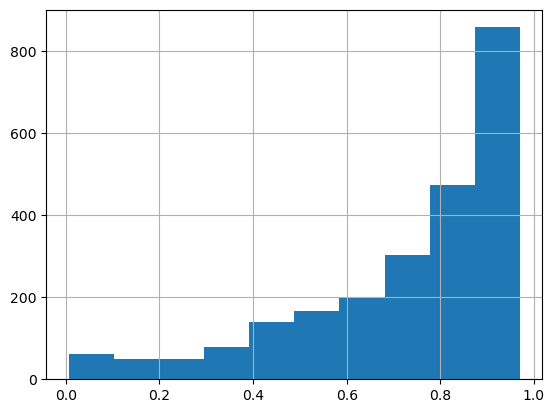

In [178]:
X_out[X_out['m2m_fact'] == 1]['model_m2m_score'].hist()

<Axes: >

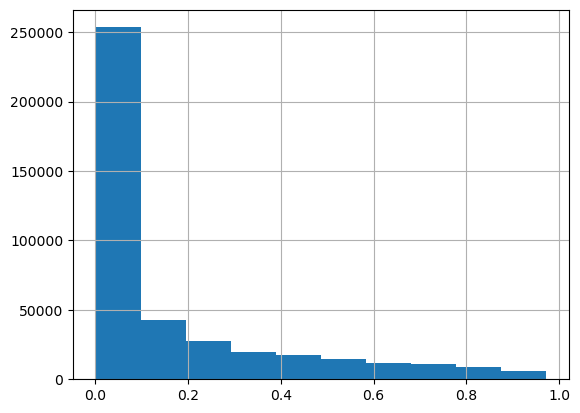

In [179]:
X_out['model_m2m_score'].hist()

<Axes: >

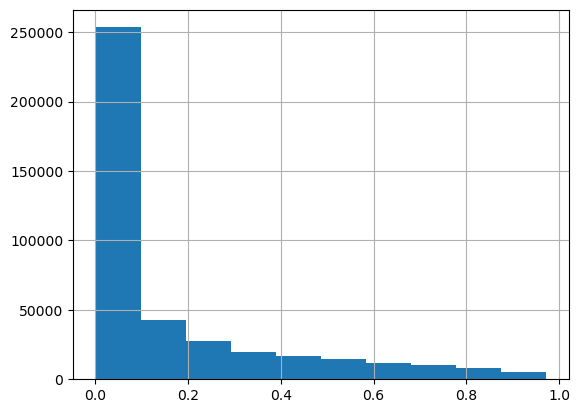

In [180]:
X_out[X_out['m2m_fact'] != 1]['model_m2m_score'].hist()

#### cutoff = 0.8

In [181]:
print(X_out[(X_out['m2m_fact'] != 1) & (X_out['model_m2m_score'] >= 0.8)].shape)
X_out[(X_out['m2m_fact'] != 1) & (X_out['model_m2m_score'] >= 0.8)]

(11570, 3)


,client_inn,m2m_fact,model_m2m_score
222337,5906118508,0,0.972303
271608,2722094650,0,0.971697
215271,6911019945,0,0.970131
267855,3808119997,0,0.969448
313452,7735140536,0,0.969319
...,...,...,...
293209,6234098017,0,0.800038
226538,7816121796,0,0.800034
291656,5044047510,0,0.800022
221187,7743869121,0,0.800017


In [182]:
X_out_2 = X_out[(X_out['m2m_fact'] != 1) & (X_out['model_m2m_score'] >= 0.8)].drop('m2m_fact', axis = 1)
X_out_2 = X_out_2.drop_duplicates()
print(X_out_2.shape)
X_out_2

(11317, 2)


,client_inn,model_m2m_score
222337,5906118508,0.972303
271608,2722094650,0.971697
215271,6911019945,0.970131
267855,3808119997,0.969448
313452,7735140536,0.969319
...,...,...
293209,6234098017,0.800038
226538,7816121796,0.800034
291656,5044047510,0.800022
221187,7743869121,0.800017


In [183]:
X_out_2['client_inn'].nunique()

11317

In [184]:
X_out_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11317 entries, 222337 to 204604
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_inn       11317 non-null  object 
 1   model_m2m_score  11317 non-null  float64
dtypes: float64(1), object(1)
memory usage: 265.2+ KB


In [185]:
print(X_out.shape)
print(X_out_2.shape)

(413718, 3)
(11317, 2)


In [186]:
X_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413718 entries, 222337 to 179593
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   client_inn       413718 non-null  object 
 1   m2m_fact         413718 non-null  uint8  
 2   model_m2m_score  413718 non-null  float64
dtypes: float64(1), object(1), uint8(1)
memory usage: 9.9+ MB


In [187]:
X_out = X_out[X_out['m2m_fact'] != 1]
X_out.shape

(411339, 3)

In [188]:
303711 - 301361

2350

In [189]:
X_out = X_out.drop('m2m_fact', axis = 1)
X_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411339 entries, 222337 to 179593
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   client_inn       411339 non-null  object 
 1   model_m2m_score  411339 non-null  float64
dtypes: float64(1), object(1)
memory usage: 9.4+ MB


#### Spark download

In [190]:
from pyspark.sql.types import StringType, FloatType, LongType, ByteType, ArrayType, StructType, StructField, IntegerType, DateType

In [191]:
# спарк датафрейм создавать, например, вот так:

mySchema = StructType(
    [
        StructField("client_inn", StringType(), True)
        ,StructField("model_m2m_score", FloatType(), True)
    ]
)
                   
# X_out_sdf = spark.createDataFrame(X_out_2, schema = mySchema)
X_out_sdf = spark.createDataFrame(X_out, schema = mySchema)

In [ ]:
# ********************* Insert into general df: ***************************

# X_out_sdf.write.mode("append").insertInto("b2b_stg.cvm_box_model_scores")

In [192]:
# resulting_table ='b2b_cltv_stg.df_m2m_score_cvmbox20250915'
# resulting_table ='b2b_cltv_stg.df_m2m_score_cvmbox20250915_allnottarg'
resulting_table ='b2b_cltv_stg.df_m2m_score_cvmbox20251028_allnottarg'

db_name, table_name = resulting_table.split(".")
   
(
    X_out_sdf
    .repartition(10)
    .write.mode("overwrite")
    .format("parquet")
    .option("path", f"hdfs://ns-etl/warehouse/tablespace/external/hive/{db_name}.db/{table_name}")
    #.partitionBy("transaction_dt")
    .saveAsTable(resulting_table)
)

# где res_sdf - это твой спарк-датафрейм
# resulting_table ='b2b_cltv_stg.your_table_name'

In [193]:
# df_check = spark.table('b2b_cltv_stg.df_m2m_score_cvmbox20250915')
df_check = spark.table('b2b_cltv_stg.df_m2m_score_cvmbox20251028_allnottarg')

print(df_check.count())
df_check.show(3)

411339
+----------+---------------+
|client_inn|model_m2m_score|
+----------+---------------+
|6607000556|      0.9350902|
|2353019708|     0.93838227|
|1655338434|      0.9343488|
+----------+---------------+
only showing top 3 rows



In [194]:
df_check.describe()

DataFrame[summary: string, client_inn: string, model_m2m_score: string]